# Fisher Scoring, Quasi Newton, Steepest Ascent, Newton Raphson



### Loading the Libraries

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
from sympy import *
from numpy.linalg import inv
from tabulate import tabulate
from matplotlib import ticker, cm
from scipy.stats import *
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from scipy.misc import factorial

### Reading the Data

In [2]:
data = pd.read_table("oilspills.dat", sep="\s+")

### Newton's Method

#### - Newton-Raphson Function

In [3]:
def Newton(f1,f2,Hessian,a01,a02,eps):
    i = 0
    nitr = 1
    alpha1 = np.zeros(6)
    alpha2 = np.zeros(6)
    alpha1[0] = a01
    alpha2[0] = a02
    while abs(f1(alpha1[i],alpha2[i]))+abs(f2(alpha1[i],alpha2[i]))>eps:
        nitr +=1 
        if i==5:
            alpha1[0] = alpha1[i]
            alpha2[0] = alpha2[i]
            i=0
            
        [[alpha1[i+1]],[alpha2[i+1]]] = [[alpha1[i]],[alpha2[i]]]-inv(Hessian(alpha1[i],alpha2[i])).dot([[f1(alpha1[i],alpha2[i])],[f2(alpha1[i],alpha2[i])]])
        i+=1

    ID = np.concatenate((np.arange(nitr%5,5), np.arange(0,nitr%5)), axis=None)

    print(tabulate({"Iteration": list(np.arange(nitr-4,nitr+1)),'\u03B11' : list(alpha1[ID]), '\u03B12': list(alpha2[ID]),
                   'Hessian Matrix':np.array(Hessian(alpha1[ID],alpha2[ID])).T},headers="keys"))

    return alpha1[i],alpha2[i]

#### - Parameteric Loglikelihood for Poisson

In [4]:
def lglklihd_N(x0,b1,b2):
    l = 1
    alpha1 = sym.Symbol('a1')
    alpha2 = sym.Symbol('a2')
    for i in range(0,len(x0)):
        l *= (alpha1*b1[i]+alpha2*b2[i])**x0[i]*exp(-(alpha1*b1[i]+alpha2*b2[i]))/np.math.factorial(x0[i])
    return log(l)

#### - First derivatives and Hessian Matrix as a function of '$\alpha1$' and '$\alpha2$'

In [5]:
alpha1 = sym.Symbol('a1')
alpha2 = sym.Symbol('a2')

fprime_alpha1 = sum(data['spills']*data['importexport']/(alpha1*data['importexport']+alpha2*data['domestic']))-sum(data['importexport'])
fprime_alpha2 = sum(data['spills']*data['domestic']/(alpha1*data['importexport']+alpha2*data['domestic']))-sum(data['domestic'])
fzegond_alpha12 = sum(-data['spills']*data['importexport']*data['domestic']/(alpha1*data['importexport']+alpha2*data['domestic'])**2)
fzegond_alpha11 = sum(-data['spills']*data['importexport']**2/(alpha1*data['importexport']+alpha2*data['domestic'])**2)
fzegond_alpha22 = sum(-data['spills']*data['domestic']**2/(alpha1*data['importexport']+alpha2*data['domestic'])**2)

f1 = lambdify([alpha1,alpha2], fprime_alpha1, 'numpy')
f2 = lambdify([alpha1,alpha2], fprime_alpha2, 'numpy')
f12 = lambdify([alpha1,alpha2], fzegond_alpha12, 'numpy')
f11 = lambdify([alpha1,alpha2], fzegond_alpha11, 'numpy')
f22 = lambdify([alpha1,alpha2], fzegond_alpha22, 'numpy')
fL = lglklihd_N(data['spills'],data['importexport'],data['domestic'])
f = lambdify([alpha1,alpha2], fL, 'numpy')

H = [[f11(alpha1,alpha2),f12(alpha1,alpha2)],[f12(alpha1,alpha2),f22(alpha1,alpha2)]]
Hessian = lambdify([alpha1,alpha2], H, 'numpy')

#### - Newton method results

In [6]:
Newton(f1,f2,Hessian,1,2.5,0.001)

  Iteration       α1         α2  Hessian Matrix
-----------  -------  ---------  -----------------------------
          3  1.46632  -0.151379  [[-25.60561759 -21.69858305]
                                  [-21.69858305 -25.24918444]]
          4  1.26448   0.430203  [[-18.89001991 -12.39814664]
                                  [-12.39814664 -12.47097462]]
          5  1.12388   0.838783  [[-17.08210149  -9.64022263]
                                  [ -9.64022263  -8.88094872]]
          6  1.09816   0.93353   [[-16.67804626  -9.12079917]
                                  [ -9.12079917  -8.24586964]]
          7  1.09715   0.937548  [[-16.66035932  -9.09932411]
                                  [ -9.09932411  -8.22003943]]


(1.097154238380797, 0.9375476997530862)

### Fisher Scoring

#### - Fisher Matrix as a function of '$\alpha1$' and '$\alpha2$' for Fisher scoring Method

In [7]:
alpha1 = sym.Symbol('a1')
alpha2 = sym.Symbol('a2')

fisher11 = sum(data['importexport']**2/(alpha1*data['importexport']+alpha2*data['domestic']))
fisher12 = sum(data['importexport']*data['domestic']/(alpha1*data['importexport']+alpha2*data['domestic']))
fisher22 = sum(data['domestic']**2/(alpha1*data['importexport']+alpha2*data['domestic']))

fisher_f11 = lambdify([alpha1,alpha2], fisher11, 'numpy')
fisher_f12 = lambdify([alpha1,alpha2], fisher12, 'numpy')
fisher_f22 = lambdify([alpha1,alpha2], fisher22, 'numpy')
F = [[fisher_f11(alpha1,alpha2),fisher_f12(alpha1,alpha2)],[fisher_f12(alpha1,alpha2),fisher_f22(alpha1,alpha2)]]
Fisher = lambdify([alpha1,alpha2], F, 'numpy')

#### - Fisher Scoring function 

In [8]:
def Fisher_N(f1,f2,Fisher,a01,a02,eps):
    i = 0
    nitr = 1
    alpha1 = np.zeros(6)
    alpha2 = np.zeros(6)
    alpha1[0] = a01
    alpha2[0] = a02
    std_err_alpha1 = np.zeros(6)+100
    std_err_alpha2 = np.zeros(6)+100
    while abs(f1(alpha1[i],alpha2[i]))+abs(f2(alpha1[i],alpha2[i]))>eps:
        nitr +=1
#         print(alpha2[i])
        if i==5:
            alpha1[0] = alpha1[i]
            alpha2[0] = alpha2[i]
            std_err_alpha1[0] = std_err_alpha1[i]
            std_err_alpha2[0] = std_err_alpha2[i]
            i=0
            
        [[alpha1[i+1]],[alpha2[i+1]]] = [[alpha1[i]],[alpha2[i]]]+inv(Fisher(alpha1[i],alpha2[i])).dot([[f1(alpha1[i],alpha2[i])],[f2(alpha1[i],alpha2[i])]])
        
        std_err_alpha1[i+1]=inv(Fisher(alpha1[i],alpha2[i]))[0][0]
        std_err_alpha2[i+1]=inv(Fisher(alpha1[i],alpha2[i]))[1][1]
        i+=1

    ID = np.concatenate((np.arange(nitr%5,5), np.arange(0,nitr%5)), axis=None)

    print(tabulate({"Iteration": list(np.arange(nitr-4,nitr+1)),'\u03B11' : list(alpha1[ID]), '\u03B12': list(alpha2[ID]),
                   'Fisher Matrix':np.array(Fisher(alpha1[ID],alpha2[ID])).T,'Standard Error \u03B11':list(std_err_alpha1[ID]),
                   'Standard Error \u03B12':list(std_err_alpha2[ID])},headers="keys"))

    return alpha1[i],alpha2[i]

#### - Fisher scoring method results

In [9]:
Fisher_N(f1,f2,Fisher,1,1.5,0.001)

  Iteration       α1        α2  Fisher Matrix                  Standard Error α1    Standard Error α2
-----------  -------  --------  ---------------------------  -------------------  -------------------
          4  1.10521  0.925342  [[16.39177757  9.39504691]              0.19028              0.400375
                                 [ 9.39504691  7.895992  ]]
          5  1.09462  0.941395  [[16.41849852  9.38820348]              0.191825             0.398222
                                 [ 9.38820348  7.87501341]]
          6  1.09795  0.936341  [[16.41003133  9.39033089]              0.191338             0.398918
                                 [ 9.39033089  7.88158977]]
          7  1.0969   0.937938  [[16.41270092  9.38965609]              0.191492             0.3987
                                 [ 9.38965609  7.87950931]]
          8  1.09723  0.937434  [[16.41185791  9.38986878]              0.191444             0.398769
                                 [ 9.38986878  7

(1.0972323167554459, 0.9374336680489825)

**Newton method reaches the global maximum faster than fisher scoring.**

### Steepest Ascent Without Backtracking

#### - Steepest Ascent function (without backtracking)

In [10]:
def steepest_ascent(f1,f2,a01,a02,eps,step_size):
    i = 0
    nitr = 1
    alpha1 = np.zeros(6)
    alpha2 = np.zeros(6)
    alpha1[0] = a01
    alpha2[0] = a02
    step = np.zeros(6)
    step[0] = step_size
    M=-np.eye(2)
    while abs(f1(alpha1[i],alpha2[i]))+abs(f2(alpha1[i],alpha2[i]))>eps:
        nitr +=1 
        if i==5:
            alpha1[0] = alpha1[i]
            alpha2[0] = alpha2[i]
            step[0] = step[i]
            i=0
            
        [[alpha1[i+1]],[alpha2[i+1]]]  = [[alpha1[i]],[alpha2[i]]]  + step[i]*inv(M).dot([[f1(alpha1[i],alpha2[i])],[f2(alpha1[i],alpha2[i])]])
        step[i+1]=step[i]/2
        i+=1
        
        if nitr > 100:
            print('Steepest ascent does not converge after 100 iterations')
            break

    ID = np.concatenate((np.arange(nitr%5,5), np.arange(0,nitr%5)), axis=None)

    print(tabulate({"Iteration": list(np.arange(nitr-4,nitr+1)),'\u03B11' : list(alpha1[ID]), '\u03B12': list(alpha2[ID]),
                   'Step size':list(step[ID])},headers="keys"))

    return alpha1[i],alpha2[i]


#### - Steepest Ascent result without backtracking

In [11]:
steepest_ascent(f1,f2,1,2.5,0.001,1)

Steepest ascent does not converge after 100 iterations
  Iteration       α1       α2    Step size
-----------  -------  -------  -----------
         97  33.4834  25.6634  1.26218e-29
         98  33.4834  25.6634  6.31089e-30
         99  33.4834  25.6634  3.15544e-30
        100  33.4834  25.6634  1.57772e-30
        101  33.4834  25.6634  2.52435e-29


(33.483418355462234, 25.663408447606606)

### Steepest Ascent With Backtracking

#### - Steepest Ascent function (with backtracking)

In [12]:
def steepest_ascent_backtrack(f,f1,f2,a01,a02,eps,step):
    i = 0
    nitr = 1
    alpha1 = np.zeros(6)
    alpha2 = np.zeros(6)
    alpha1[0] = a01
    alpha2[0] = a02
    step_size = np.zeros(6)
    M=-np.eye(2)
    while abs(f1(alpha1[i],alpha2[i]))+abs(f2(alpha1[i],alpha2[i]))>eps:
        nitr +=1
        step_size[i] = step
#         print(alpha1[i])
#         print(alpha2[i])
        if i==5:
            alpha1[0] = alpha1[i]
            alpha2[0] = alpha2[i]
            step_size [0] = step
            i=0
            
        [[alpha1[i+1]],[alpha2[i+1]]]  = [[alpha1[i]],[alpha2[i]]]  - step*inv(M).dot([[f1(alpha1[i],alpha2[i])],[f2(alpha1[i],alpha2[i])]])
        while f(alpha1[i+1],alpha2[i+1])<f(alpha1[i],alpha2[i]):
            step=step/2
            [[alpha1[i+1]],[alpha2[i+1]]]  = [[alpha1[i]],[alpha2[i]]]  - step*inv(M).dot([[f1(alpha1[i],alpha2[i])],[f2(alpha1[i],alpha2[i])]])

        
        i+=1
        
        if nitr > 100:
            print('Steepest ascent backtracking does not converge after 100 iterations')
            break

    ID = np.concatenate((np.arange(nitr%5,5), np.arange(0,nitr%5)), axis=None)

    print(tabulate({"Iteration": list(np.arange(nitr-4,nitr+1)),'\u03B11' : list(alpha1[ID]), '\u03B12': list(alpha2[ID]),'Step size':list(step_size[ID])},headers="keys"))

    return alpha1[i],alpha2[i]

#### - Steepest Ascent result with backtracking

In [13]:
steepest_ascent_backtrack(f,f1,f2,1.5,.5,0.001,1)

  Iteration       α1        α2    Step size
-----------  -------  --------  -----------
         43  1.09744  0.937108       0.0625
         44  1.0974   0.937175       0.0625
         45  1.09736  0.937232       0.0625
         46  1.09733  0.937281       0.0625
         47  1.0973   0.937322       0.0625


(1.0973011169729079, 0.9373218987813381)

### Quasi Newton without Backtracking

#### - Quasi Newton function (without backtracking)

In [14]:
def Q_Newton(f,f1,f2,a01,a02,eps,step):
    i = 0
    nitr = 1
    alpha1 = np.zeros(6)
    alpha2 = np.zeros(6)
    alpha1[0] = a01
    alpha2[0] = a02
    step_size = np.zeros(6)
    M = [-np.eye(2),-np.eye(2),-np.eye(2),-np.eye(2),-np.eye(2),-np.eye(2)]
    while abs(f1(alpha1[i],alpha2[i]))+abs(f2(alpha1[i],alpha2[i])) > eps:
        nitr +=1
        step_size[i] = step
        if i==5:
            alpha1[0] = alpha1[i]
            alpha2[0] = alpha2[i]
            step_size [0] = step
            M[0] = M[i]
            i=0
            
        [[alpha1[i+1]],[alpha2[i+1]]]  = [[alpha1[i]],[alpha2[i]]]  - step*inv(M[i]).dot([[f1(alpha1[i],alpha2[i])],[f2(alpha1[i],alpha2[i])]])

        step = step/2
        Z = np.array([[alpha1[i+1]-alpha1[i]],[alpha2[i+1]-alpha2[i]]])
        Y = np.array([[f1(alpha1[i+1],alpha2[i+1])-f1(alpha1[i],alpha2[i])],[f2(alpha1[i+1],alpha2[i+1])-f2(alpha1[i],alpha2[i])]])
        V = Y - M[i].dot(Z)
        M[i+1] = M[i] - (M[i].dot(Z).dot((M[i].dot(Z)).T))/(Z.T.dot(M[i]).dot(Z))+Y.dot(Y.T)/((Z.T).dot(Y))
        if abs(V.T.dot(Z)) < eps:
            M[i+1] = M[i]           

        i+=1
        
        if nitr > 100:
            print('Quasi Newton does not converge after 100 iterations')
            break

    ID = np.concatenate((np.arange(nitr%5,5), np.arange(0,nitr%5)), axis=None)

    print(tabulate({"Iteration": list(np.arange(nitr-4,nitr+1)),'\u03B11' : list(alpha1[ID]), '\u03B12': list(alpha2[ID]),
                    'Step size':list(step_size[ID]),'M Matrix': np.array(M)[ID]},headers="keys"))

    return alpha1[i],alpha2[i]

#### - Quasi Newton's method results without backtracking

In [15]:
Q_Newton(f,f1,f2,1.1,0.9,0.0001,1)

Quasi Newton does not converge after 100 iterations
  Iteration       α1       α2    Step size  M Matrix
-----------  -------  -------  -----------  -----------------------------
         97  1.17246  1.00493  1.26218e-29  [[-13.84712197  -8.15459027]
                                             [ -8.15459027  -6.15459416]]
         98  1.17246  1.00493  6.31089e-30  [[-13.84712197  -8.15459027]
                                             [ -8.15459027  -6.15459416]]
         99  1.17246  1.00493  3.15544e-30  [[-13.84712197  -8.15459027]
                                             [ -8.15459027  -6.15459416]]
        100  1.17246  1.00493  1.57772e-30  [[-13.84712197  -8.15459027]
                                             [ -8.15459027  -6.15459416]]
        101  1.17246  1.00493  2.52435e-29  [[-13.84712197  -8.15459027]
                                             [ -8.15459027  -6.15459416]]


C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


(1.1724604095105484, 1.0049296132546197)

### Quasi Newton with Backtracking

#### - Quasi Newton function (with backtracking)

In [16]:
def Q_Newton_backtrack(f,f1,f2,a01,a02,eps,step):
    i = 0
    nitr = 1
    alpha1 = np.zeros(6)
    alpha2 = np.zeros(6)
    alpha1[0] = a01
    alpha2[0] = a02
    step_size = np.zeros(6)
    M = [-np.eye(2),-np.eye(2),-np.eye(2),-np.eye(2),-np.eye(2),-np.eye(2)]
    while abs(f1(alpha1[i],alpha2[i]))+abs(f2(alpha1[i],alpha2[i])) > eps:
        nitr +=1
        step_size[i] = step
#         print(alpha2[i])
        if i==5:
            alpha1[0] = alpha1[i]
            alpha2[0] = alpha2[i]
            step_size [0] = step
            M[0] = M[i]
            i=0
            
        [[alpha1[i+1]],[alpha2[i+1]]]  = [[alpha1[i]],[alpha2[i]]]  - step*inv(M[i]).dot([[f1(alpha1[i],alpha2[i])],[f2(alpha1[i],alpha2[i])]])
       
        while f(alpha1[i+1],alpha2[i+1])<f(alpha1[i],alpha2[i]):
            step=step/2
            [[alpha1[i+1]],[alpha2[i+1]]]  = [[alpha1[i]],[alpha2[i]]]  - step*inv(M[i]).dot([[f1(alpha1[i],alpha2[i])],[f2(alpha1[i],alpha2[i])]])

#         step = step/2
        
        Z = np.array([[alpha1[i+1]-alpha1[i]],[alpha2[i+1]-alpha2[i]]])
        Y = np.array([[f1(alpha1[i+1],alpha2[i+1])-f1(alpha1[i],alpha2[i])],[f2(alpha1[i+1],alpha2[i+1])-f2(alpha1[i],alpha2[i])]])
        V = Y - M[i].dot(Z)
        M[i+1] = M[i] - (M[i].dot(Z).dot((M[i].dot(Z)).T))/(Z.T.dot(M[i]).dot(Z))+Y.dot(Y.T)/((Z.T).dot(Y))
        if abs(V.T.dot(Z)) < eps:
            M[i+1] = M[i]           

        i+=1
        
        if nitr > 100:
#             print('Quasi Newton backtracking does not converge after 100 iterations')
            break

    ID = np.concatenate((np.arange(nitr%5,5), np.arange(0,nitr%5)), axis=None)

    print(tabulate({"Iteration": list(np.arange(nitr-4,nitr+1)),'\u03B11' : list(alpha1[ID]), '\u03B12': list(alpha2[ID]),
                    'Step size':list(step_size[ID]),'M Matrix': np.array(M)[ID]},headers="keys"))

    return alpha1[i],alpha2[i]

#### - Quasi Newton's method results with backtracking

In [17]:
Q_Newton_backtrack(f,f1,f2,1,.2,0.0001,1)

  Iteration       α1        α2    Step size  M Matrix
-----------  -------  --------  -----------  -----------------------------
         97  1.09744  0.937755       0.0625  [[-13.39085964  -7.54559361]
                                              [ -7.54559361  -6.52994737]]
         98  1.09742  0.93774        0.0625  [[-13.39085964  -7.54559361]
                                              [ -7.54559361  -6.52994737]]
         99  1.0974   0.937727       0.0625  [[-13.39085964  -7.54559361]
                                              [ -7.54559361  -6.52994737]]
        100  1.09738  0.937714       0.0625  [[-13.39085964  -7.54559361]
                                              [ -7.54559361  -6.52994737]]
        101  1.09746  0.937771       0.0625  [[-13.39085964  -7.54559361]
                                              [ -7.54559361  -6.52994737]]


(1.0973595151386142, 0.9377021294201133)

**Quasi Newton without step halving backtracking does not converge but with backtracking it converges.**

### Graph for all methods

#### - Initial Values

In [18]:
alpha0 = np.linspace(-.5,2.5,100)
alpha1 = np.linspace(-.5,2.5,100)

#### - Numerical loglikelihood function for poisson

In [19]:
def lglklihd_N(x0,b1,b2,alpha0,alpha1):
    X, Y = np.meshgrid(alpha0,alpha1)
    n = len(alpha1)
    x = np.reshape(X,n**2)
    y = np.reshape(Y,n**2)
    l = np.zeros(n**2)
    for i in range(0,n**2-1):
        l[i] = sum(x0*np.log(x[i]*b1+y[i]*b2))-sum((x[i]*b1+y[i]*b2))-sum(np.log(factorial(x0)))
    return X, Y, np.reshape(l,(n,n))

#### - log-likelihood computation for a grid of $\alpha1$ and $\alpha2$

In [20]:
X, Y, l =lglklihd_N(data['spills'],data['importexport'],data['domestic'],alpha0,alpha1)

C:\ProgramData\Anaconda\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  
C:\ProgramData\Anaconda\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### - Lets plot `Newton-Raphson`, `Fisher scoring`, `Steepest Ascent` and `Quasi Newton` traces

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: linewidths is ignored by contourf
  This is separate from the ipykernel package so we can avoid doing imports until


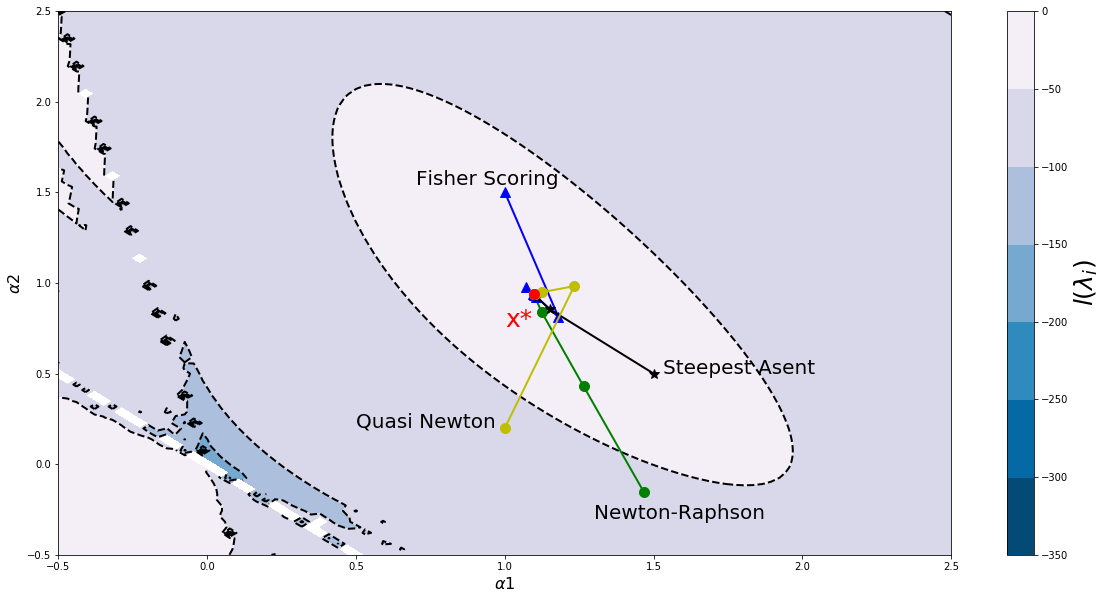

In [21]:
plt.figure(figsize = (20,10))
plt.contour(X, Y, l, colors='black', linestyles='dashed', linewidths=2)
cs = plt.contourf(X, Y, l, linewidths=1,cmap=cm.PuBu_r)
plt.ylabel(r'$\alpha2$',weight='bold',fontsize=16)
plt.xlabel(r'$\alpha1$',weight='bold',fontsize=16)
# Newton's Method
plt.plot([1.46632,1.26448,1.12388,1.09816,1.09715],[-0.151379,0.430203,0.838783,0.93353,0.937548],marker='o',ms=10,linewidth=2,color='g')
plt.text(1.3,-0.3, 'Newton-Raphson', fontsize=20)
         
# Fisher Scoring
plt.plot([1.0,1.1801888670933343,1.071924035873405,1.1052106682989804,1.094618369915091,1.097953423887773,1.096899813427851],
         [1.5,0.8117092409964791,0.9757895194027143,0.9253421132224043,0.941395223435636,0.9363407973752859,0.9379375919728272],marker='^',ms=10,linewidth=2,color='b')
plt.text(.7,1.54, 'Fisher Scoring', fontsize=20)

# Steepest Asent
plt.plot([1.5,1.150776613767146,1.1075336443763262,1.099177844073335,1.0973274656446057],
         [0.5,0.8553265639516938,0.92136128844898,0.9343852011842726,0.937280639070089],marker='*',ms=10,linewidth=2,color='k')
plt.text(1.53,.5, 'Steepest Asent', fontsize=20)

# Quasi Newton
plt.plot([1.0,1.2329710086116585,1.1254844523076506,1.1026592096491146,1.0982164777888395,1.0973771273370907],
         [0.2,0.9826324317526023,0.9495600312109526,0.9404937171136707,0.9382268098441964,0.9377138636031992],marker='o',ms=10,linewidth=2,color='y')
plt.text(.5,.2, 'Quasi Newton', fontsize=20)

plt.text(1.,.758, 'x*', fontsize=25,color='r')
plt.plot([1.0973595151386144],[0.9377021294201132],marker='o',ms=10,linewidth=2,color='r')
# plt.text(0, 2, r'$\alpha_{(2)}$', fontsize=20)
cbar = plt.colorbar(cs)
cbar.set_label(r'$l(\lambda_{i})$',fontsize=25, rotation=90)


####  $x^{*}$ is the true maximum likelihood (red dot in the plot)

**I selected the starting point, end point and randomly couple of $\alpha1$ and $\alpha2$ values between for those that reach the general maxima with more than 10 iterations.**